# PyOD, SUOD, and TOD comparison 

## 1. NAB Ambient Temperature dataset
The NAB Ambient Temperature dataset consists of continuous temperature readings collected from an industrial machine. It is designed to simulate real-world scenarios where anomalies can occur due to unexpected environmental changes or equipment malfunctions. Here we'll use this as comparison for PyOD, SUOD, and TOD

### Attributes:
- Timestamp
- Ambient Temperature


In [1]:
import time
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd 

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns


# For pyOD
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.knn import KNN

# For suOD (suOD can used the initialized models from pyOD)
from suod.models.base import SUOD  



url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv' # Url for the CSV
data = pd.read_csv(url)
X = data[['value']].values

# Standard Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Contamination level
contamination = 0.05

### Base estimators used in PyOD and SUOD. TOD will use the same estimators but I had to put them in a dictionary since it can't accept arrays
The outliers detected by the three models (PyOD, SUOD, TOD) are listed in two ways:

1. Outliers detected on each estimator. This one is listed on an array
2. Aggregated outliers which is combined by all estimators by taking the mean and checked whether it is within an accepted threshold which is defined by the contamination level

The training and inference times by the three models (PyOD, SUOD, TOD) are listed in two ways:

1. Times are listed on each estimator which is presented by an array
2. Total training and inference times are also printed

In [2]:
base_estimators = [
    LOF(n_neighbors=5, contamination=contamination),
    LOF(n_neighbors=15, contamination=contamination),
    LOF(n_neighbors=25, contamination=contamination),
    HBOS(contamination=contamination),
    PCA(contamination=contamination),
    KNN(n_neighbors=5, contamination=contamination),
    KNN(n_neighbors=15, contamination=contamination),
    KNN(n_neighbors=25, contamination=contamination)
]


### 1.A PyOD Implementation

In [3]:
pyod_scores = []
pyod_outlier_counts = []
pyod_training_times = []
pyod_inference_times = []

def get_outlier_ids(labels):
    return np.where(labels == 1)[0]

for estimator in base_estimators:
    start_time = time.time()
    estimator.fit(X_scaled)
    end_time = time.time()
    training_time = end_time - start_time
    pyod_training_times.append(training_time)

    start_time = time.time()
    pyod_predictions = estimator.predict(X_scaled)
    end_time = time.time()
    inference_time = end_time - start_time
    pyod_scores.append(pyod_predictions)
    pyod_inference_times.append(inference_time)
    pyod_outlier_ids = get_outlier_ids(pyod_predictions)
    pyod_outlier_counts.append(len(pyod_outlier_ids)) 


print(f"PyOD Training times for each base estimator: {pyod_training_times} in seconds")
print(f"PyOD Inference times for each base estimator: {pyod_inference_times} in seconds")
print(f"PyOD Total Training Time: {sum(pyod_training_times):.4f} seconds")
print(f"PyOD Total Inference Time: {sum(pyod_inference_times):.4f} seconds")

scores = np.array(pyod_scores).T
combined_scores = np.mean(scores, axis=1) 
threshold_index = int((1 - contamination) * len(combined_scores))
threshold = np.sort(combined_scores)[threshold_index]
pyod_labels = (combined_scores > threshold).astype(int) 

PyOD Training times for each base estimator: [0.006725788116455078, 0.016940832138061523, 0.020864486694335938, 2.4319069385528564, 0.00677180290222168, 0.00670170783996582, 0.013815879821777344, 0.021041154861450195] in seconds
PyOD Inference times for each base estimator: [0.014403581619262695, 0.010138273239135742, 0.026144027709960938, 0.0, 0.0005195140838623047, 0.40288829803466797, 0.4024190902709961, 0.40241265296936035] in seconds
PyOD Total Training Time: 2.5248 seconds
PyOD Total Inference Time: 1.2589 seconds


### 1.B SUOD Implementation

In [4]:
# Joblib is used to do some CPU parallelization
n_jobs = min(2, len(base_estimators))
print(f"Number of jobs: {n_jobs}")

suod_model = SUOD(
    base_estimators=base_estimators,
    n_jobs=n_jobs,  # Number of parallel jobs
    rp_flag_global=True,  # Random projection 
    bps_flag=True,  # Balanced parallel scheduling
    approx_flag_global=False,  # No model approximation
    contamination=contamination
)

suod_training_times = []
suod_inference_times = []

for estimator in suod_model.base_estimators:

    start_train_time = time.time()
    estimator.fit(X_scaled)
    end_train_time = time.time()
    suod_training_times.append(end_train_time - start_train_time)


    start_inf_time = time.time()
    decision_scores = estimator.decision_function(X_scaled)
    end_inf_time = time.time()
    suod_inference_times.append(end_inf_time - start_inf_time)



start_time_suod = time.time()
suod_model.fit(X_scaled)
suod_model.approximate(X_scaled)  
end_time_suod = time.time()
suod_training_time = end_time_suod - start_time_suod

start_time_suod = time.time()
suod_outliers = suod_model.predict(X_scaled)
end_time_suod = time.time()
suod_inference_time = end_time_suod - start_time_suod

print(f"SUOD Training times for each base estimator: {suod_training_times} in seconds")
print(f"SUOD Inference times for each base estimator: {suod_inference_times} in seconds")
print(f"SUOD Total Training Time: {sum(suod_training_times):.4f} seconds")
print(f"SUOD Total Inference Time: {sum(suod_inference_times):.4f} seconds")

combined_scores = np.mean(suod_outliers, axis=1)
threshold_index = int((1 - contamination) * len(combined_scores))
threshold = np.sort(combined_scores)[threshold_index]
suod_labels = (combined_scores > threshold).astype(int)


Number of jobs: 2
RandomForestRegressor()



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished


SUOD Training times for each base estimator: [0.013865947723388672, 0.016080617904663086, 0.017418622970581055, 0.0, 0.006833791732788086, 0.0069768428802490234, 0.013943910598754883, 0.01386117935180664] in seconds
SUOD Inference times for each base estimator: [0.007500886917114258, 0.014429330825805664, 0.020801305770874023, 0.0, 0.0001304149627685547, 0.4096946716308594, 0.39565038681030273, 0.41034770011901855] in seconds
SUOD Total Training Time: 0.0890 seconds
SUOD Total Inference Time: 1.2586 seconds


### 1.C TOD Implementaion
This one involves converting the x data into tensors. We can't also use the base estimators array a while ago for some reason but I made sure TOD is still using the same base estimators with the same settings. They're just presented differently so that the TOD looping works. You can double check below

In [5]:
# For TOD
from pytod.models.knn import KNN
from pytod.models.hbos import HBOS
from pytod.models.pca import PCA
from pytod.models.lof import LOF
import torch

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Estimators for TOD
base_estimators = []


lof_params = [
    {'n_neighbors': 5, 'contamination': contamination},
    {'n_neighbors': 15, 'contamination': contamination},
    {'n_neighbors': 25, 'contamination': contamination},
]


for params in lof_params:
    base_estimators.append(LOF(**params))

base_estimators.append(HBOS(contamination=contamination))
base_estimators.append(PCA(contamination=contamination, n_components=min(5, X_tensor.shape[1]), device='cuda:0'))


knn_params = [
    {'n_neighbors': 5, 'contamination': contamination},
    {'n_neighbors': 15, 'contamination': contamination},
    {'n_neighbors': 25, 'contamination': contamination},
]


for params in knn_params:
    base_estimators.append(KNN(**params))



In [6]:
print(f"X_tensor shape: {X_tensor.shape}")
num_samples, num_features = X_tensor.shape
n_components = min(5, num_samples, num_features)
start_time_tod = time.time()
scores = []
tod_training_times = []
tod_inference_times = []
tod_outlier_counts = []

def get_outlier_ids(labels):
    return np.where(labels == 1)[0]



for clf in base_estimators:
    
    start_time_train_suod = time.time()
    clf.fit(X_tensor)
    end_time_train_suod = time.time()
    tod_training_times.append(end_time_train_suod - start_time_train_suod)

    start_time_inf_suod = time.time()
    decision_scores = clf.decision_scores_
    end_time_inf_suod =  time.time()
    tod_inference_times.append(end_time_inf_suod - start_time_inf_suod)

    scores.append(decision_scores)

    threshold_index = int((1 - contamination) * len(decision_scores))
    threshold = np.sort(decision_scores)[threshold_index]
    predicted_labels = (decision_scores > threshold).astype(int)

    outlier_ids = get_outlier_ids(predicted_labels)
    tod_outlier_counts.append(len(outlier_ids))


scores = np.array(scores).T
combined_scores = np.mean(scores, axis=1) 

threshold_index = int((1 - contamination) * len(combined_scores))
threshold = np.sort(combined_scores)[threshold_index]
tod_labels = (combined_scores > threshold).astype(int) 

print("TOD Predicted labels:", tod_labels)
print("TOD Training times for each base estimator:", tod_training_times)
print("TOD Inference times for each base estimator:", tod_inference_times)
print("TOD Total training time:", sum(tod_training_times))
print("TOD Total inference time:", sum(tod_inference_times))

X_tensor shape: torch.Size([7267, 1])
TOD Predicted labels: [0 0 0 ... 0 0 0]
TOD Training times for each base estimator: [2.166271686553955, 0.03474593162536621, 0.041586875915527344, 0.12508034706115723, 0.06940555572509766, 0.020789384841918945, 0.029309749603271484, 0.019267559051513672]
TOD Inference times for each base estimator: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
TOD Total training time: 2.5064570903778076
TOD Total inference time: 0.0


### 1.D Outlier Results
Here we present the number of outliers for each estimator as well as the number of outliers when the estimator results are aggregated. We also present a line chart to visualize the points marked as anomalies.

              timestamp      value  pyod_outlier  suod_outlier  tod_outlier
0   2013-07-04 00:00:00  69.880835             0             0            0
1   2013-07-04 01:00:00  71.220227             0             0            0
2   2013-07-04 02:00:00  70.877805             0             0            0
3   2013-07-04 03:00:00  68.959400             0             0            0
4   2013-07-04 04:00:00  69.283551             0             0            0
5   2013-07-04 05:00:00  70.060966             0             0            0
6   2013-07-04 06:00:00  69.279765             0             0            0
7   2013-07-04 07:00:00  69.369608             0             0            0
8   2013-07-04 08:00:00  69.166714             0             0            0
9   2013-07-04 09:00:00  68.986083             0             0            0
10  2013-07-04 10:00:00  69.965062             0             0            0
11  2013-07-04 11:00:00  70.556195             0             0            0
12  2013-07-

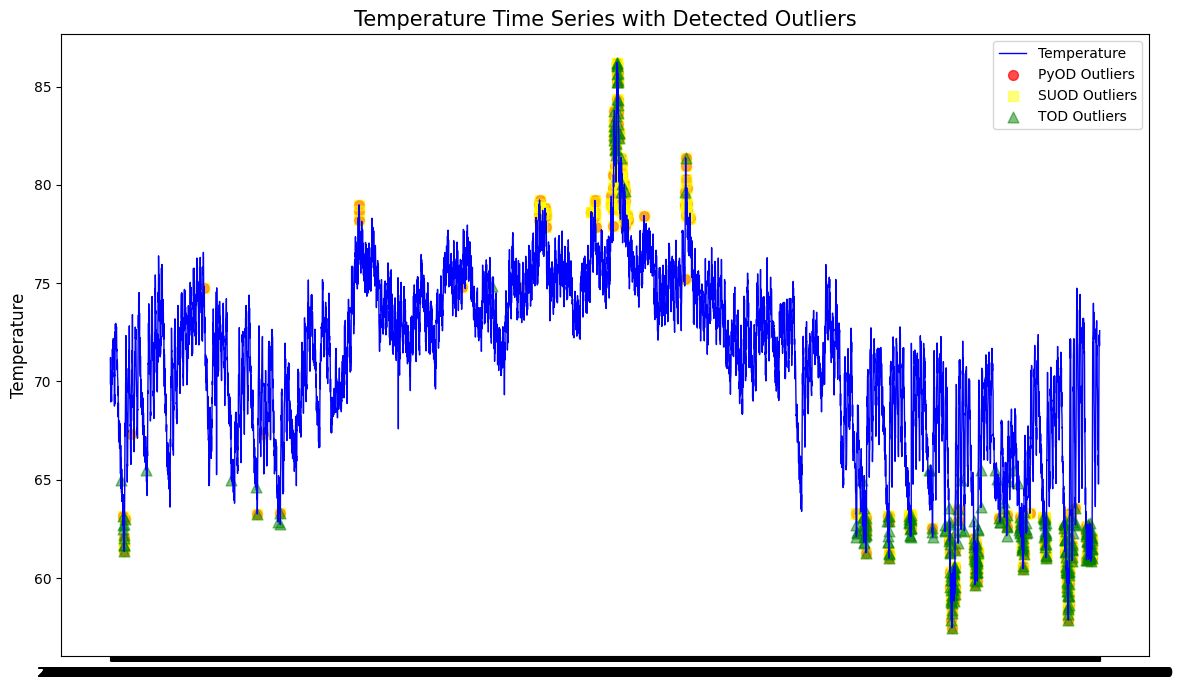

In [7]:
data['pyod_outlier'] = pyod_labels
data['suod_outlier'] = suod_labels
data['tod_outlier'] = tod_labels

print(data.head(20))

num_pyod_outliers = sum(pyod_labels)
num_suod_outliers_1 = sum(suod_outliers)
num_suod_outliers_2 = sum(suod_labels)
num_tod_outliers = sum(tod_labels)

print(f"Number of outliers detected by PyOD (For each base estimator): {pyod_outlier_counts}")
print(f"Number of outliers detected by PyOD (Aggregated): {num_pyod_outliers}")
print(f"Number of outliers detected by SUOD (For each base estimator): {num_suod_outliers_1}")
print(f"Number of outliers detected by SUOD (Aggregated): {num_suod_outliers_2}")
print(f"Number of outliers detected by TOD (For each base estimator): {tod_outlier_counts}")
print(f"Number of outliers detected by TOD (Aggregated): {num_tod_outliers}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plot the main time series data
plt.plot(data['timestamp'], data['value'], label='Temperature', color='blue', lw=1)

# Plot PyOD outliers 
plt.scatter(
    data['timestamp'][data['pyod_outlier'] == 1], 
    data['value'][data['pyod_outlier'] == 1], 
    color='red', marker='o', label='PyOD Outliers', s=50, alpha=0.7
)

# Plot suOD outliers 
plt.scatter(
    data['timestamp'][data['suod_outlier'] == 1], 
    data['value'][data['suod_outlier'] == 1], 
    color='yellow', marker='s', label='SUOD Outliers', s=60, alpha=0.5
)

# Plot TOD outliers
plt.scatter(
    data['timestamp'][data['tod_outlier'] == 1], 
    data['value'][data['tod_outlier'] == 1], 
    color='green', marker='^', label='TOD Outliers', s=60, alpha=0.5
)


plt.ylabel('Temperature', fontsize=12)
plt.title('Temperature Time Series with Detected Outliers', fontsize=15)
plt.legend(loc='best', fontsize=10)  
plt.tight_layout()
plt.show()


### 1.E Display training and inference times
Here we display each library's training and inference times for all the estimators. Keep in mind our data is small, that's why the results are in seconds. There is a also a bar graph to visualize the speed of each estimator

               Model PyOD Training Time SUOD Training Time TOD Training Time PyOD Inference Time SUOD Inference Time TOD Inference Time
 LOF (n_neighbors=5)           0.006726           0.013866          2.166272            0.014404            0.007501                0.0
LOF (n_neighbors=15)           0.016941           0.016081          0.034746            0.010138            0.014429                0.0
LOF (n_neighbors=25)           0.020864           0.017419          0.041587            0.026144            0.020801                0.0
                HBOS           2.431907                0.0           0.12508                 0.0                 0.0                0.0
                 PCA           0.006772           0.006834          0.069406             0.00052             0.00013                0.0
 KNN (n_neighbors=5)           0.006702           0.006977          0.020789            0.402888            0.409695                0.0
KNN (n_neighbors=15)           0.013816         

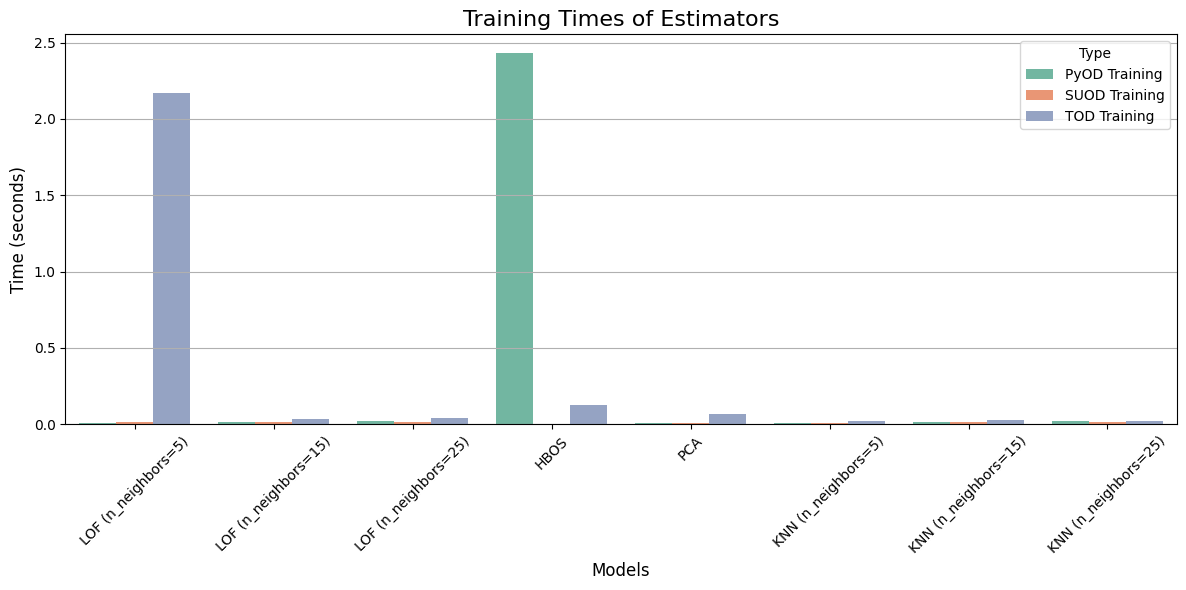

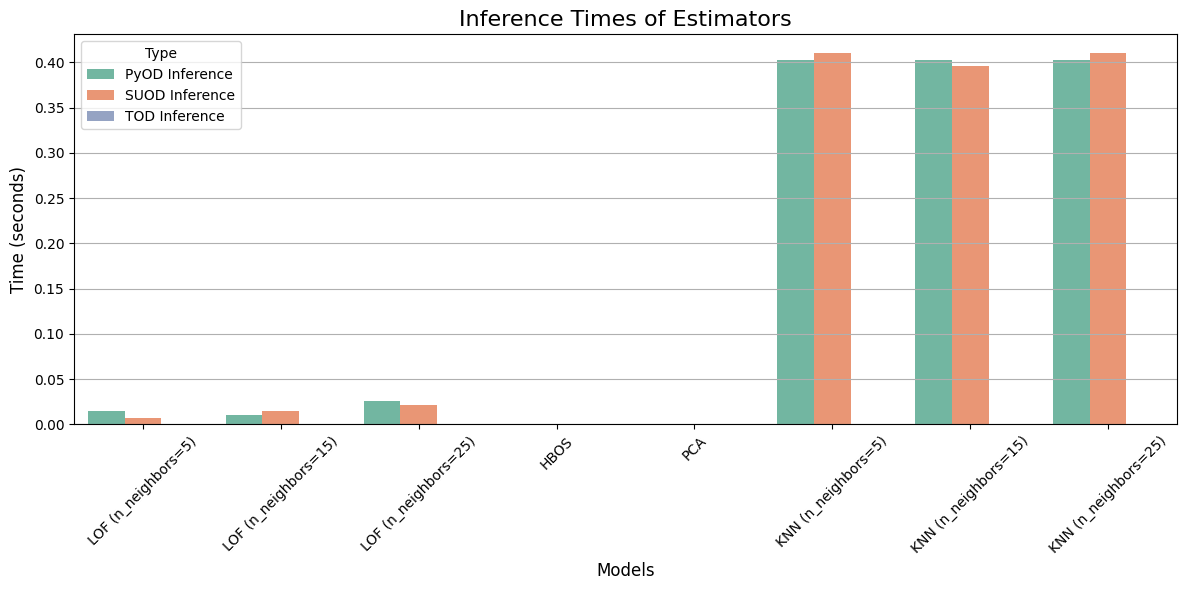

In [8]:

model_names = [
    "LOF (n_neighbors=5)",
    "LOF (n_neighbors=15)",
    "LOF (n_neighbors=25)",
    "HBOS",
    "PCA",
    "KNN (n_neighbors=5)",
    "KNN (n_neighbors=15)",
    "KNN (n_neighbors=25)",
]


results_df = pd.DataFrame({
    'Model': model_names,
    'PyOD Training Time': pyod_training_times,
    'SUOD Training Time': suod_training_times,
    'TOD Training Time': tod_training_times,
    'PyOD Inference Time': pyod_inference_times,
    'SUOD Inference Time': suod_inference_times,
    'TOD Inference Time': tod_inference_times
})

total_times = {
    'Total Training Time': [
        sum(pyod_training_times),
        sum(suod_training_times),
        sum(tod_training_times)
    ],
    'Total Inference Time': [
        sum(pyod_inference_times),
        sum(suod_inference_times),
        sum(tod_inference_times)
    ]
}

totals_df = pd.DataFrame({
    'Model': ['Total pyOD', 'Total suOD', 'Total TOD'],
    'PyOD Training Time': [total_times['Total Training Time'][0], '___', '___'],
    'PyOD Inference Time': [total_times['Total Inference Time'][0], '___', '___'],
    'SUOD Training Time': ['___', total_times['Total Training Time'][1], '___'],
    'SUOD Inference Time': ['___', total_times['Total Inference Time'][1], '___'],
    'TOD Training Time': ['___', '___', total_times['Total Training Time'][2]],
    'TOD Inference Time': ['___', '___', total_times['Total Inference Time'][2]],
})


final_results_df = pd.concat([results_df, totals_df], ignore_index=True)
print(final_results_df.to_string(index=False))


data_training = {
    'Model': model_names * 3,  
    'Time': (pyod_training_times + 
             suod_training_times + 
             tod_training_times),
    'Type': (['PyOD Training'] * len(pyod_training_times) +
             ['SUOD Training'] * len(suod_training_times) + 
             ['TOD Training'] * len(tod_training_times))
}

data_inference = {
    'Model': model_names * 3,  
    'Time': (pyod_inference_times + 
             suod_inference_times + 
             tod_inference_times),
    'Type': (['PyOD Inference'] * len(pyod_inference_times) + 
             ['SUOD Inference'] * len(suod_inference_times) + 
             ['TOD Inference'] * len(tod_inference_times))
}



df = pd.DataFrame(data_training)
df_2 = pd.DataFrame(data_inference)

# Plot training times
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Time', hue='Type', palette='Set2')


plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Training Times of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')


plt.tight_layout()
plt.show()

# Plot inference times
plt.figure(figsize=(12, 6))
sns.barplot(data=df_2, x='Model', y='Time', hue='Type', palette='Set2')


plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Inference Times of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')


plt.tight_layout()
plt.show()

### 1.F Remarks
As seen in the results, TOD kinda struggled in the training times which is unexpected but it is really quick in inference times confirming the results from the paper that they published. Besides that, PCA and HBOS has the fastest training times for PyOD and SUOD and the fastest inference time for all the libraries. KNN is the slowest of the bunch. LOF is nearly as quick as HBOS and PCA. The problem is we can't really tell if TOD will be the most reliable library for our use case because:

- Datset is too small
- Ambient temperature is not relatable to our use case (Productivity)
- We didn't even try to test their performance on unseen data

That is why we'll be testing these libraries in a more applicable dataset

## 2. Raw KMT User Dataset
The dataset provides a collection of behaviour biometrics data (commonly known as Keyboard, Mouse and Touchscreen (KMT) dynamics). It contains raw data recorded during user activities, providing a foundation for tasks such as user authentication, anomaly detection, and behavioral analysis. The dataset consists of 1,760 KMT dynamic instances collected over 88 user sessions on the GUI application.  Each user session involves 20 iterations of data entry in which the user is assigned a fictitious card information (drawn at random from a pool) to enter 10 times and subsequently presented with 10 additional card information, each to be entered once. The 10 additional card information is drawn from a pool that has been assigned or to be assigned to other users.  A KMT data instance is collected during each data entry iteration. Thus, a total of 20 KMT data instances (i.e., 10 legitimate and 10 illegitimate) was collected during each user entry session on the GUI application. 

Here, we'll use this dataset to compare the performance of PyOD, SUOD, and TOD models for anomaly detection.

### Attributes:
- Timestamp: The exact time when the behavioral data point was recorded.

- Keystroke Dynamics:Raw keystroke events, including key press and release timings.

- Mouse Movements: Detailed mouse interaction data, such as movement trajectories, clicks, and pauses.

- Touch Gestures (if applicable): Data related to user touch interactions, including swipe directions, durations, and multi-touch patterns (on touch-enabled devices).

- Session Information: Metadata about the user's session, such as start and end times or session ID (if available).

### 2.A Data Preprocessing
Here we're only concerned about detecting anomalies in certain time periods of movement or action. So we'll do some data transformations to be able to get key events, mouse movement, and the change in time (time delta)

- Key Events: Identifying and isolating significant keystroke or interaction events.
- Mouse Movement: Capturing and analyzing the patterns and trajectories of mouse movements.
- Change in Time (Time Delta): Calculating the time difference between consecutive events to understand temporal dynamics.

In [9]:
import json
import os

# Path to one JSON file
file_path = os.path.join(r'C:\Users\Jeryl Salas\Documents\AI Work\Productivity\Behaviour Biometrics Dataset\behaviour_biometrics_dataset', 'raw_kmt_dataset', 'raw_kmt_user_0001.json')


with open(file_path, 'r') as f:
    json_data = json.load(f)

# Print the type and the keys to understand the structure
print("Type of json_data:", type(json_data))
print("Keys in json_data:", json_data.keys())


for key in json_data:
    print(f"\nSample data for key '{key}':", json_data[key])
    break  

Type of json_data: <class 'dict'>
Keys in json_data: dict_keys(['details', 'true_data', 'false_data'])

Sample data for key 'details': {'ID': 'CDID0001', 'Provider': 'Discover', 'Name': 'Mrs Ellie Miller', 'Card Number': 4422891459068728, 'CVC': 646, 'Expiry': '09/23'}


In [10]:
import pandas as pd
import json
import os

# folder paths
root_folder = r'C:\Users\Jeryl Salas\Documents\AI Work\Productivity\Behaviour Biometrics Dataset\behaviour_biometrics_dataset'
raw_folder = os.path.join(root_folder, 'raw_kmt_dataset')

# Initialize an empty list to store data
data_list = []

# Loop through each file in the raw data folder
for file_name in os.listdir(raw_folder):
    if file_name.endswith('.json'):
        file_path = os.path.join(raw_folder, file_name)
        
        # Open and load JSON data
        with open(file_path, 'r') as f:
            json_data = json.load(f)
        
        # Extract details once per file
        details = json_data.get('details', {})

        # Process true_data (legitimate entries)
        for key, inner_dict in json_data.get('true_data', {}).items():
            if isinstance(inner_dict, dict):
                entry_data = details.copy()
                entry_data.update(inner_dict)  # Flatten inner dictionary
                entry_data['class'] = 1
                data_list.append(entry_data)
                #print(f"Appended true_data entry: {entry_data}") 

        # Process false_data (illegitimate entries)
        for key, inner_dict in json_data.get('false_data', {}).items():
            if isinstance(inner_dict, dict):
                entry_data = details.copy()
                entry_data.update(inner_dict)  # Flatten inner dictionary
                entry_data['class'] = 0
                data_list.append(entry_data)
                #print(f"Appended false_data entry: {entry_data}") 

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

# Display the first few rows of the DataFrame and its shape
print("\nFinal DataFrame shape:", df.shape)
print(df.head())
print(df['key_events'].iloc[0])
print(df['mouse_events'].iloc[0])
print(len(df))


Final DataFrame shape: (1760, 9)
         ID  Provider              Name       Card Number  CVC Expiry  \
0  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23   
1  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23   
2  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23   
3  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23   
4  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23   

                                          key_events  \
0  [{'Key': 'shift', 'Event': 'pressed', 'Input B...   
1  [{'Key': 'shift', 'Event': 'pressed', 'Input B...   
2  [{'Key': 'm', 'Event': 'pressed', 'Input Box':...   
3  [{'Key': 'shift', 'Event': 'pressed', 'Input B...   
4  [{'Key': 'shift', 'Event': 'pressed', 'Input B...   

                                        mouse_events  class  
0  [{'Event': 'movement', 'Coordinates': [30.0, 5...      1  
1  [{'Event': 'left release', 'Coordinates': [408...      1  
2  [

In [11]:
expanded_data_list = []

for _, row in df.iterrows():
    # Expand key_events
    for event in row['key_events']:
        event_data = row[['ID', 'Provider', 'Name', 'Card Number', 'CVC', 'Expiry', 'class']].to_dict()
        event_data.update(event)  # Add key event details
        event_data['event_type'] = 'key_event'
        expanded_data_list.append(event_data)

    # Expand mouse_events
    for event in row['mouse_events']:
        event_data = row[['ID', 'Provider', 'Name', 'Card Number', 'CVC', 'Expiry', 'class']].to_dict()
        event_data.update(event)  # Add mouse event details
        event_data['event_type'] = 'mouse_event'
        expanded_data_list.append(event_data)

expanded_df = pd.DataFrame(expanded_data_list)
print(expanded_df.head())
print(len(expanded_df))

         ID  Provider              Name       Card Number  CVC Expiry  class  \
0  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23      1   
1  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23      1   
2  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23      1   
3  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23      1   
4  CDID0001  Discover  Mrs Ellie Miller  4422891459068728  646  09/23      1   

     Key     Event Input Box Text Changed                   Timestamp  \
0  shift   pressed      Name         True  2022-02-06 18:57:09.981740   
1      m   pressed      Name         True  2022-02-06 18:57:10.121021   
2  shift  released      Name         True  2022-02-06 18:57:10.169470   
3      m  released      Name         True  2022-02-06 18:57:10.218179   
4      r   pressed      Name         True  2022-02-06 18:57:10.293582   

                Epoch event_type Coordinates  Movement ID  false_enters  
0  164

In [12]:
expanded_df['Timestamp'] = pd.to_datetime(expanded_df['Timestamp'])
expanded_df = expanded_df.sort_values(by='Timestamp').reset_index(drop=True)
print(expanded_df)
print(len(expanded_df))

              ID    Provider              Name       Card Number  CVC Expiry  \
0       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
1       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
2       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
3       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
4       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
...          ...         ...               ...               ...  ...    ...   
881302  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881303  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881304  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881305  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881306  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   

        class  Key     Event Input Box 

In [13]:
# Example: Calculating time delta between events
expanded_df['time_delta'] = expanded_df['Timestamp'].diff().dt.total_seconds().fillna(0)
print(expanded_df)
print(len(expanded_df))

              ID    Provider              Name       Card Number  CVC Expiry  \
0       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
1       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
2       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
3       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
4       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
...          ...         ...               ...               ...  ...    ...   
881302  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881303  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881304  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881305  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881306  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   

        class  Key     Event Input Box 

In [14]:
# Ensure Coordinates column has lists only; replace NaN or non-list values
expanded_df['Coordinates'] = expanded_df['Coordinates'].apply(lambda x: x if isinstance(x, list) else [0, 0])

# Split Coordinates into X and Y columns
expanded_df[['X', 'Y']] = pd.DataFrame(expanded_df['Coordinates'].tolist(), index=expanded_df.index)
print(expanded_df)

              ID    Provider              Name       Card Number  CVC Expiry  \
0       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
1       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
2       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
3       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
4       CDID0011  MasterCard  Mrs Robyn Foster  4743617507581304  657  03/24   
...          ...         ...               ...               ...  ...    ...   
881302  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881303  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881304  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881305  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   
881306  CDID0088         JCB  Mr Myles Stevens  4168201160110329  248  10/23   

        class  Key     Event Input Box 

In [15]:
# Aggregate X and Y separately
time_window_df = expanded_df.resample('1S', on='Timestamp').agg({
    'Key': 'count',           # Number of key presses per second
    'X': 'mean',              # Average X coordinate per second
    'Y': 'mean',              # Average Y coordinate per second
    'time_delta': 'sum'       # Total time between events in this second
}).fillna(0)

print(time_window_df.head())
print(len(time_window_df))

                     Key           X           Y  time_delta
Timestamp                                                   
2022-01-25 12:30:23    0   91.062500  518.625000    0.531838
2022-01-25 12:30:24    0  187.915254  455.694915    0.993874
2022-01-25 12:30:25    0  212.500000  353.461538    0.847539
2022-01-25 12:30:26    6    0.000000    0.000000    1.148185
2022-01-25 12:30:27   14    0.000000    0.000000    1.008965
7805468


### 2.B Inject Anomalies
Since this data is meant for unsupervised learning, we're going to inject our own anomalies into the dataset. We simulated and injected multiple types of anomalies into a dataset for analysis. We begin by defining parameters that control the scale and type of anomalies, such as spikes, contextual deviations, clusters, mean shifts, noise, and patterns. Using data extracted from time_window_df, we generate random positions for anomalies, ensuring unique positions for each anomaly type. The injection process is vectorized for efficiency, modifying specific features of the dataset based on predefined conditions. After anomalies are applied, we scale the dataset using StandardScaler to normalize the values. Finally, we output a portion of the scaled data, examine the correlation matrix to observe the effect of anomalies on feature relationships, and print sample anomaly positions for verification. This process helps us prepare a robust dataset for testing anomaly detection methods while minimizing excessive correlation between features.

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

# Parameters
n_anomalies = 1000000  # Total number of anomalies to reduce correlation
anomaly_factor = 10  # Amplification factor to avoid extreme correlations
threshold = 10  # Threshold for contextual anomalies
shift_factor = 0.05  # Shift factor to reduce correlated shifts
noise_level = 0.02  # Noise level for more subtle noise-based anomalies
pattern_amplitude = 2  # Amplitude of pattern-based anomalies

# Data array from the processed dataframe
data_array = time_window_df[['Key', 'X', 'Y', 'time_delta']].values

# Generated anomaly positions
anomaly_dates = np.random.choice(time_window_df.index, size=n_anomalies, replace=False)
anomaly_positions = [time_window_df.index.get_loc(date) for date in anomaly_dates]
n_spike_anomalies = int(n_anomalies * 0.2)
n_contextual_anomalies = int(n_anomalies * 0.2)
n_cluster_anomalies = int(n_anomalies * 0.2)
n_shift_anomalies = int(n_anomalies * 0.2)
n_noise_anomalies = int(n_anomalies * 0.1)
n_pattern_anomalies = int(n_anomalies * 0.1)

# Unique positions for each anomaly type
spike_positions = np.random.choice(anomaly_positions, size=n_spike_anomalies, replace=False)
contextual_positions = np.random.choice(anomaly_positions, size=n_contextual_anomalies, replace=False)
cluster_positions = np.random.choice(anomaly_positions, size=n_cluster_anomalies, replace=False)
shift_positions = np.random.choice(anomaly_positions, size=n_shift_anomalies, replace=False)
noise_positions = np.random.choice(anomaly_positions, size=n_noise_anomalies, replace=False)
pattern_positions = np.random.choice(anomaly_positions, size=n_pattern_anomalies, replace=False)

# Vectorized Injection of Temporal Anomalies (Spikes, Drops, and Jumps)
spike_values = np.random.choice([50, -50], size=len(spike_positions))  # Random spike values
data_array[spike_positions] += spike_values[:, np.newaxis]

# Vectorized Injection of Contextual Anomalies. Contextual anomalies only applied to feature 'X' 
contextual_condition = data_array[contextual_positions, 2] > threshold  # Check threshold on feature 'Y'
data_array[contextual_positions[contextual_condition], 1] *= anomaly_factor  # Amplify 'X' if condition is met

# Vectorized Injection of Cluster-Based Anomalies. Cluster-based anomly only applied to feature 'X'
cluster_data, _ = make_blobs(n_samples=len(cluster_positions), centers=5, n_features=1, center_box=(10, 20))
data_array[cluster_positions, 1] = cluster_data[:, 0]

# Vectorized Injection of Shift-Based Anomalies (Mean Shifts). Shifts only applied to feature 'Y'
shift_increments = np.arange(len(shift_positions)) * shift_factor  # 1D array of size len(shift_positions)
data_array[shift_positions, 2] += shift_increments  # Apply the shifts directly to 'Y' feature


# Adding Noise-Based Anomalies. Small random noise added
noise = np.random.normal(loc=0, scale=noise_level, size=(len(noise_positions), data_array.shape[1]))
data_array[noise_positions] += noise  

# Adding Pattern-Based Anomalies (Cyclic Pattern). Cyclic patterns only on feature 'X'
pattern = pattern_amplitude * np.sin(np.linspace(0, 2 * np.pi, len(pattern_positions)))
data_array[pattern_positions, 1] += pattern  

# Scaling the data after anomaly injection
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_array)

# Output results for verification
print("Scaled Data (first 10 rows):")
print("_"*50)
print(scaled_data[:10])

# Examine correlation matrix before and after anomaly injection
print("\nCorrelation Matrix Before Anomaly Injection:")
print("_"*50)
print(np.corrcoef(time_window_df.T))  # Transpose to get correlations across features
print("Correlation Matrix After Anomaly Injection:")
print("_"*50)
print(f"{np.corrcoef(scaled_data.T)}\n")

# Sample anomaly positions for verification
print("_"*50)
print("Sample Spike Positions:", spike_positions[:10])
print("Sample Contextual Positions:", contextual_positions[:10])
print("Sample Cluster Positions:", cluster_positions[:10])
print("Sample Shift Positions:", shift_positions[:10])
print("Sample Noise Positions:", noise_positions[:10])
print("Sample Pattern Positions:", pattern_positions[:10])


Scaled Data (first 10 rows):
__________________________________________________
[[4.24084132e-01 2.94269201e-02 5.45544345e-02 2.95030193e-05]
 [4.24084132e-01 4.22143822e-02 4.85177030e-02 2.97723988e-05]
 [4.24084132e-01 4.54603043e-02 3.87107012e-02 2.96870815e-05]
 [4.74900238e-01 1.74039449e-02 4.80398678e-03 2.98623663e-05]
 [5.42655046e-01 1.74039449e-02 4.80398678e-03 2.97811972e-05]
 [5.25716344e-01 1.74039449e-02 4.80398678e-03 2.97091357e-05]
 [4.32553483e-01 1.74039449e-02 4.80398678e-03 2.94259769e-05]
 [4.91838940e-01 1.74039449e-02 4.80398678e-03 3.01593707e-05]
 [4.24084132e-01 1.74039449e-02 4.80398678e-03 2.91929434e-05]
 [4.66430887e-01 1.74039449e-02 4.80398678e-03 3.03786052e-05]]

Correlation Matrix Before Anomaly Injection:
__________________________________________________
[[1.00000000e+00 3.42034370e-02 2.89545792e-02 2.73180785e-05]
 [3.42034370e-02 1.00000000e+00 8.27507724e-01 3.96831743e-02]
 [2.89545792e-02 8.27507724e-01 1.00000000e+00 3.86688056e-02]
 [2

### 2.C Visualize Data
Here we analyze how much the data has changed after injecting anomalies and standard scaling the data. Through these visualizations, we gain insights into the nature of injected anomalies and validate whether they align with the intended types and patterns. Through this, we can get added insights as to why the models performed that way it did

#### 2.C.1 Line Chart Visualization
This code visualizes the first 300 data points of a time series dataset to analyze the effects of injected anomalies on the feature "X." It overlays the original "X" values with their manipulated counterparts, highlighting changes introduced during anomaly injection. Various types of anomalies, including spike, contextual, cluster-based, shift, noise, and pattern-based, are represented as scatter points in distinct colors, enabling clear differentiation. This visualization effectively demonstrates the impact of anomalies on the data, validating the injection process and aiding in their identification.

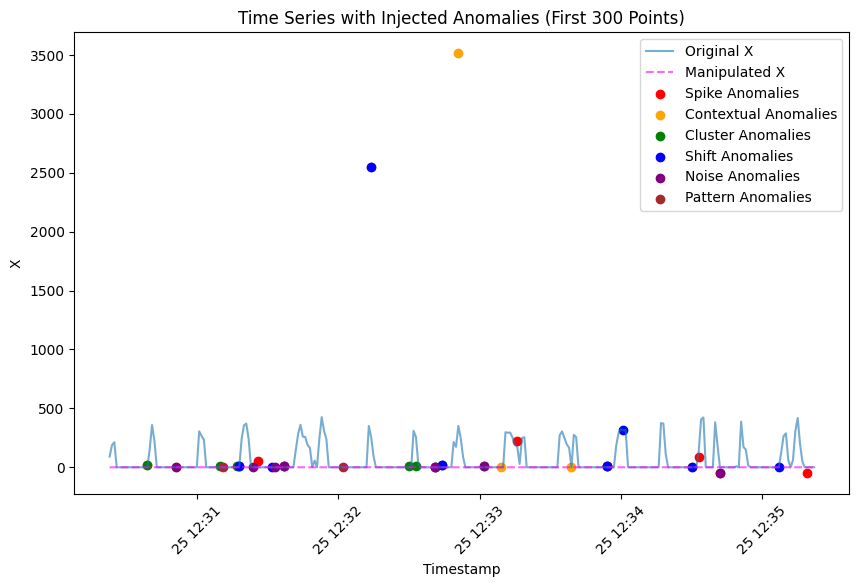

In [17]:
import matplotlib.pyplot as plt

num_points = 300
# Select first 30 points for the plot
subset_df = time_window_df.iloc[:num_points]

vis_data = pd.DataFrame(scaled_data, columns=['Key', 'X', 'Y', 'time_delta'])
subset_2_df = vis_data.iloc[:num_points]
manipulated_X = subset_2_df['X'] 

# Plotting 'X' over time using the Timestamp as the index for the first 30 points
plt.figure(figsize=(10, 6))
plt.plot(subset_df.index, subset_df['X'], label='Original X', alpha=0.6)
plt.plot(subset_df.index, manipulated_X, label='Manipulated X', linestyle='--', alpha=0.6, color='magenta')  # Add Manipulated X

# Plot anomalies on the same graph (only for the first 30 points)
subset_spike_positions = [pos for pos in spike_positions if pos < num_points]
subset_contextual_positions = [pos for pos in contextual_positions if pos < num_points]
subset_cluster_positions = [pos for pos in cluster_positions if pos < num_points]
subset_shift_positions = [pos for pos in shift_positions if pos < num_points]
subset_noise_positions = [pos for pos in noise_positions if pos < num_points]
subset_pattern_positions = [pos for pos in pattern_positions if pos < num_points]

# Adding anomaly points
plt.scatter(subset_df.iloc[subset_spike_positions].index, data_array[subset_spike_positions, 1], color='red', label='Spike Anomalies')
plt.scatter(subset_df.iloc[subset_contextual_positions].index, data_array[subset_contextual_positions, 1], color='orange', label='Contextual Anomalies')
plt.scatter(subset_df.iloc[subset_cluster_positions].index, data_array[subset_cluster_positions, 1], color='green', label='Cluster Anomalies')
plt.scatter(subset_df.iloc[subset_shift_positions].index, data_array[subset_shift_positions, 1], color='blue', label='Shift Anomalies')
plt.scatter(subset_df.iloc[subset_noise_positions].index, data_array[subset_noise_positions, 1], color='purple', label='Noise Anomalies')
plt.scatter(subset_df.iloc[subset_pattern_positions].index, data_array[subset_pattern_positions, 1], color='brown', label='Pattern Anomalies')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('X')
plt.title(f'Time Series with Injected Anomalies (First {num_points} Points)')
plt.legend()
plt.xticks(rotation=45)  # Rotate timestamp labels for better readability
plt.show()


#### 2.C.2 Boxplots
This section generates side-by-side boxplots to compare the distribution of key features ("Key," "X," "Y," and "time_delta") before and after data manipulation. Using a shared figure, the first plot displays the original feature distributions, while the second showcases the manipulated distributions, highlighting the impact of injected anomalies and transformations. 

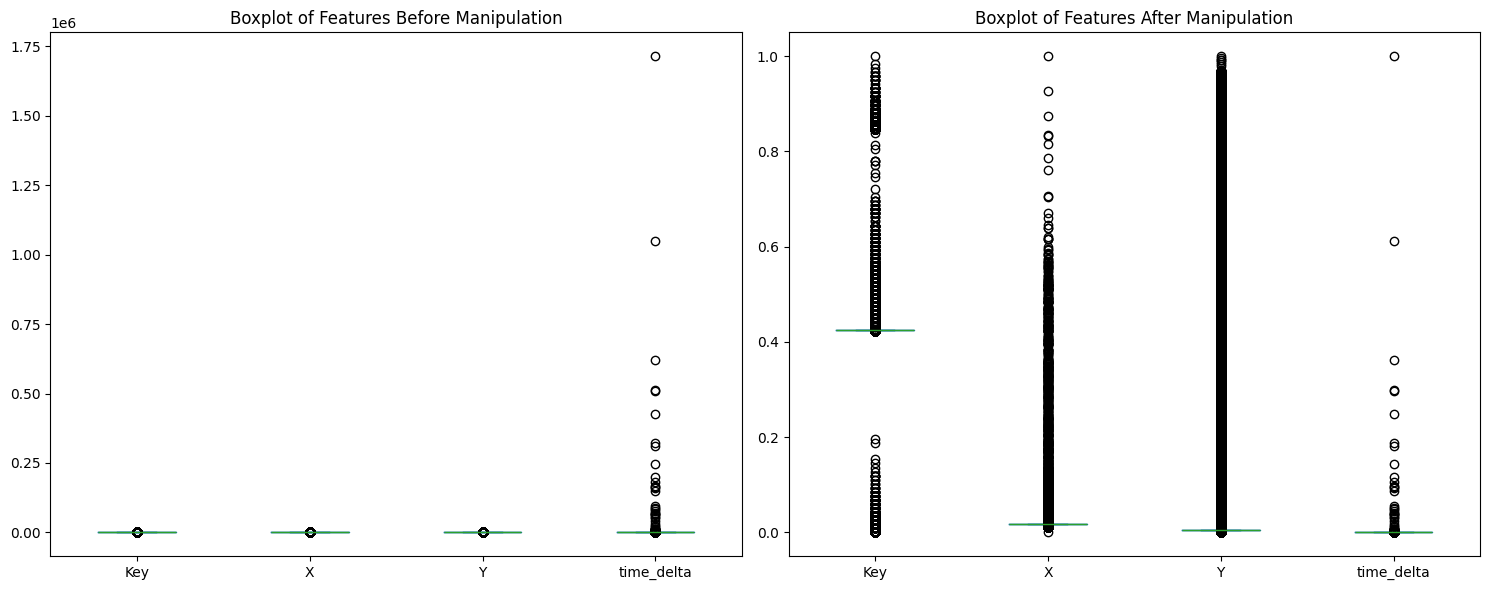

In [18]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot boxplot for 'X', 'Y', and 'time_delta' before manipulation
time_window_df[['Key', 'X', 'Y', 'time_delta']].plot.box(ax=axes[0])
axes[0].set_title('Boxplot of Features Before Manipulation')

# Plot boxplot for 'X', 'Y', and 'time_delta' after manipulation
vis_data[['Key', 'X', 'Y', 'time_delta']].plot.box(ax=axes[1])
axes[1].set_title('Boxplot of Features After Manipulation')

# Display the plots
plt.tight_layout()
plt.show()


#### 2.C.3 Descriptive Statistics
This section calculates and displays the descriptive statistics for the features ("Key," "X," "Y," and "time_delta") before and after data manipulation. It  providing key summary metrics such as count, mean, standard deviation, min, and max values. The printed output helps us understand how the data characteristics have changed due to the injection of anomalies and scaling, enabling a clear comparison between the original and manipulated datasets.

In [19]:
# Get descriptive statistics
print("Data before manipulation")
print("_"*75)
descriptive_stats = time_window_df[['Key', 'X', 'Y', 'time_delta']].describe()
print(descriptive_stats)

print("\nData after manipulation")
print("_"*75)
vis_data = pd.DataFrame(scaled_data, columns=['Key', 'X', 'Y', 'time_delta'])
descriptive_stats = vis_data[['Key', 'X', 'Y', 'time_delta']].describe()
print(descriptive_stats)

Data before manipulation
___________________________________________________________________________
                Key             X             Y    time_delta
count  7.805468e+06  7.805468e+06  7.805468e+06  7.805468e+06
mean   2.210796e-02  7.958815e-01  6.938761e-01  9.999999e-01
std    3.644005e-01  1.509788e+01  1.345507e+01  8.490413e+02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
max    5.300000e+01  8.490000e+02  6.710000e+02  1.715136e+06

Data after manipulation
___________________________________________________________________________
                Key             X             Y    time_delta
count  7.805468e+06  7.805468e+06  7.805468e+06  7.805468e+06
mean   4.242943e-01  1.769254e-02  1.716054e-02  2.977755e-05
std    6.785526e-02  4.691806e-03  8.781107e-02  4.950

#### 2.C.4 Rolling mean and std. dev
This section generates two side-by-side plots that display the rolling mean and standard deviation of the "Y" feature, both before and after the data manipulation. The comparison between the two plots highlights how the manipulation (such as anomaly injection) has impacted the data's mean and variability.

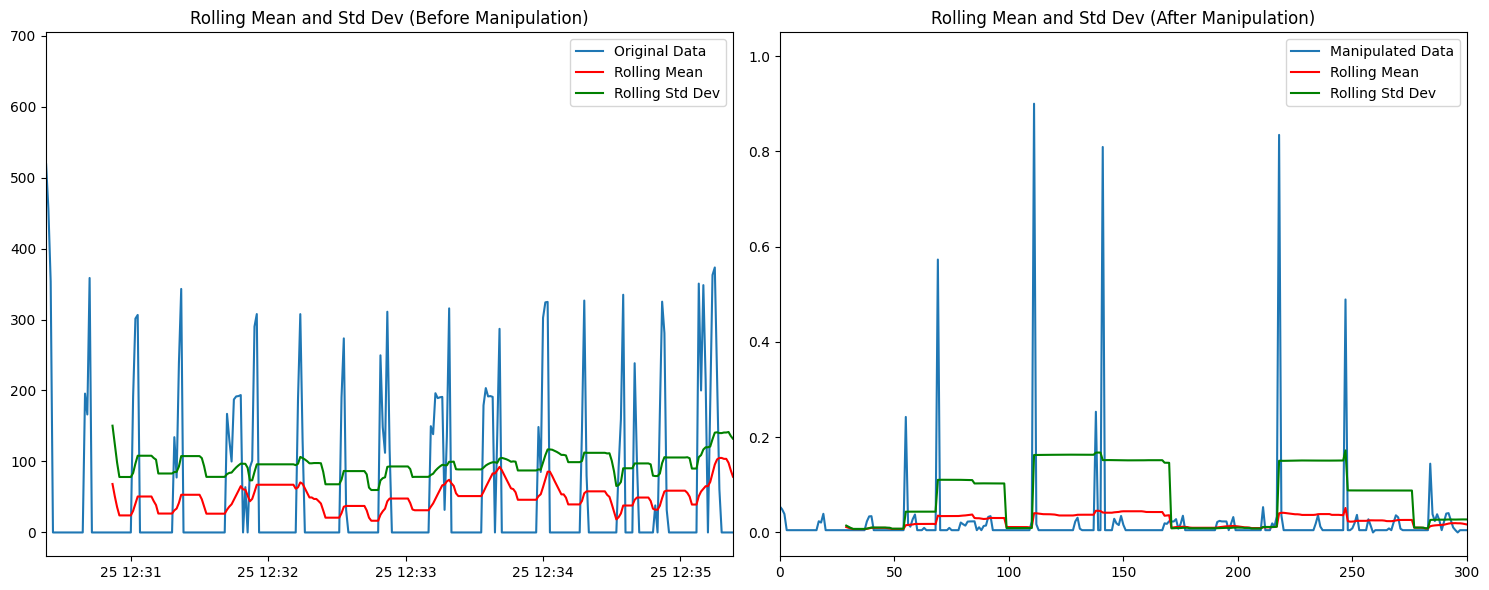

In [20]:
import matplotlib.pyplot as plt

xlim = 300  # Set xlim as desired

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the 'time_window_df' data
rolling_mean = time_window_df['Y'].rolling(window=30).mean()
rolling_std = time_window_df['Y'].rolling(window=30).std()

axes[0].plot(time_window_df['Y'], label='Original Data')
axes[0].plot(rolling_mean, label='Rolling Mean', color='red')
axes[0].plot(rolling_std, label='Rolling Std Dev', color='green')
axes[0].set_title('Rolling Mean and Std Dev (Before Manipulation)')
axes[0].legend()
axes[0].set_xlim(time_window_df.index[0], time_window_df.index[xlim])  # Set xlim for the first plot

# Plot for the 'vis_data' data
rolling_mean = vis_data['Y'].rolling(window=30).mean()
rolling_std = vis_data['Y'].rolling(window=30).std()

axes[1].plot(vis_data['Y'], label='Manipulated Data')
axes[1].plot(rolling_mean, label='Rolling Mean', color='red')
axes[1].plot(rolling_std, label='Rolling Std Dev', color='green')
axes[1].set_title('Rolling Mean and Std Dev (After Manipulation)')
axes[1].legend()
axes[1].set_xlim(0, xlim)  # Set xlim for the second plot

# Display the plots
plt.tight_layout()
plt.show()


#### 2.C.5 Kernel Denstiy Estimation Plots
This section compares the distributions of original and manipulated data using Kernel Density Estimation (KDE) plots and evaluates their statistical properties through skewness and kurtosis. The KDE plots are created to visualize the density distributions of these datasets, with the original data in blue and the manipulated data in orange, showing how the shape of the data changes after manipulation. Additionally, skewness and kurtosis are calculated for the features before and after manipulation to assess the asymmetry (skewness) and the "tailedness" (kurtosis) of the data distributions, providing further insight into the statistical impact of the manipulation on the datasets. The resulting plots and statistical values help in understanding how the data's characteristics evolve through the manipulation process.

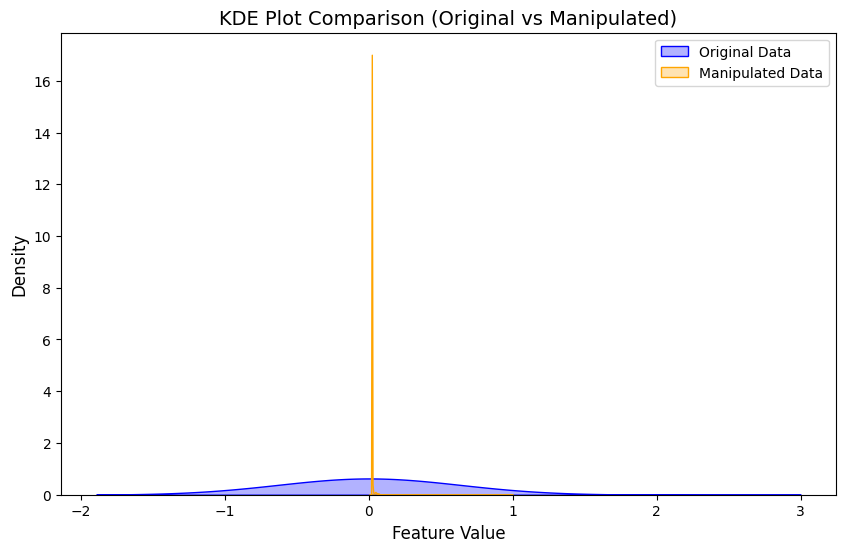


Before manipulation
__________________________________________________
Skewness: Key             27.084717
X               22.298695
Y               22.577337
time_delta    1444.255854
dtype: float64
Kurtosis: Key           1.220016e+03
X             5.702914e+02
Y             5.585210e+02
time_delta    2.518865e+06
dtype: float64

After manipulation
__________________________________________________
Skewness: Key              0.014937
X               44.582202
Y                7.929151
time_delta    1444.063587
dtype: float64
Kurtosis: Key           3.588329e+01
X             4.235851e+03
Y             6.543452e+01
time_delta    2.518417e+06
dtype: float64


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
import numpy as np
original_data = time_window_df['X'] # Simulating original data
manipulated_data = vis_data['X']  # Simulating manipulated data

# Create KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(original_data, color='blue', label='Original Data', fill=True, alpha=0.3, clip=(-3, 3))
sns.kdeplot(manipulated_data, color='orange', label='Manipulated Data', fill=True, alpha=0.3, clip=(-3, 3))

# Add titles and labels
plt.title('KDE Plot Comparison (Original vs Manipulated)', fontsize=14)
plt.xlabel('Feature Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()


from scipy.stats import skew, kurtosis

print("\nBefore manipulation")
print("_"*50)
skewness = time_window_df[['Key','X', 'Y', 'time_delta']].apply(skew)
kurt = time_window_df[['Key', 'X', 'Y', 'time_delta']].apply(kurtosis)

print('Skewness:', skewness)
print('Kurtosis:', kurt)

print("\nAfter manipulation")
print("_"*50)
skewness = vis_data[['Key','X', 'Y', 'time_delta']].apply(skew)
kurt = vis_data[['Key','X', 'Y', 'time_delta']].apply(kurtosis)

print('Skewness:', skewness)
print('Kurtosis:', kurt)

#### 2.C.6 Correlation Map Comparison
This section visualizes the correlation between features before and after manipulating the data using heatmaps. It calculates the correlation matrix for a set of features (Key, X, Y, and time_delta) both before and after data manipulation. By comparing these heatmaps side by side, one can observe how the relationships between features have changed due to the manipulation, providing insights into how the data transformation impacts the interdependence of features.

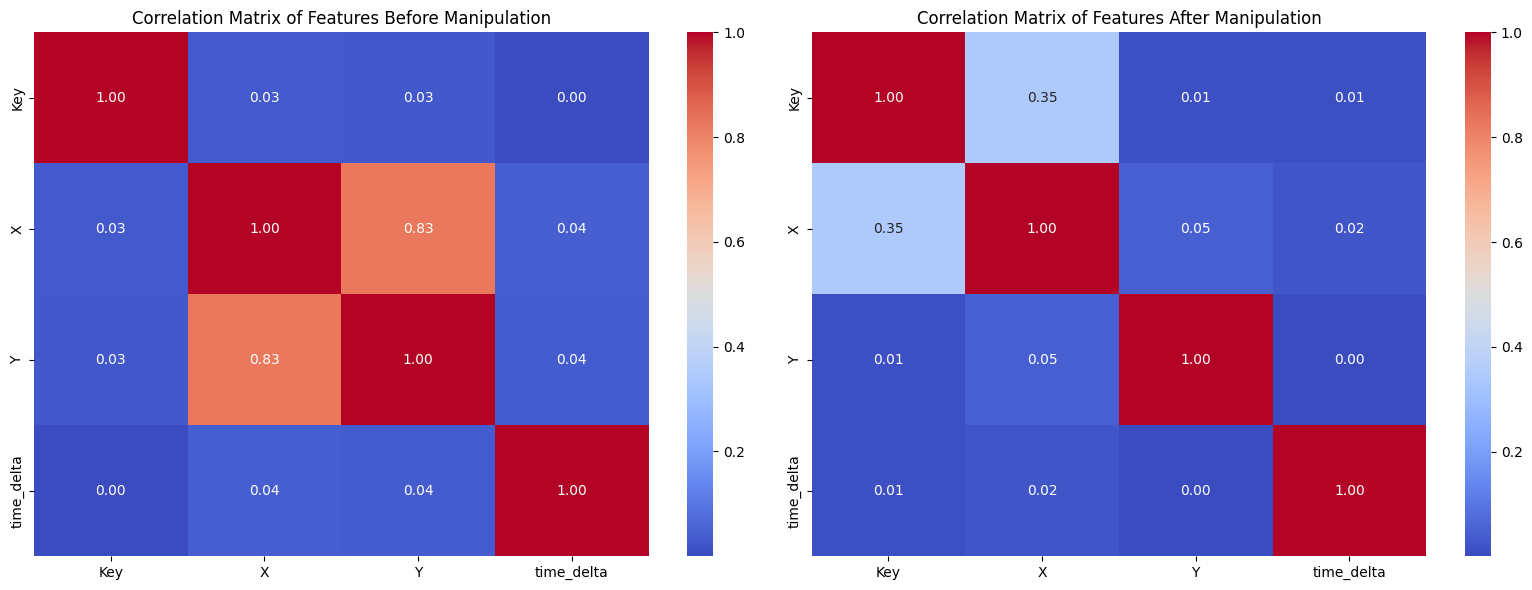

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix before manipulation
correlation_matrix_before = time_window_df[['Key', 'X', 'Y', 'time_delta']].corr()

# Calculate the correlation matrix after manipulation
correlation_matrix_after = vis_data[['Key', 'X', 'Y', 'time_delta']].corr()

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first heatmap (before manipulation)
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, ax=axes[0])
axes[0].set_title('Correlation Matrix of Features Before Manipulation')

# Plot the second heatmap (after manipulation)
sns.heatmap(correlation_matrix_after, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, ax=axes[1])
axes[1].set_title('Correlation Matrix of Features After Manipulation')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


### 2.D PCA with Elbow Method
PCA is applied to both datasets (original and manipulated datasets), and the cumulative explained variance is computed for each. The results are visualized in two side-by-side plots, where the x-axis represents the number of principal components, and the y-axis shows the cumulative explained variance. The plots include a horizontal line at 95% variance to highlight the optimal number of components that capture most of the variance in the data. The optimal number of components for both the original and manipulated datasets is determined by identifying the first component where the cumulative explained variance reaches or exceeds 95%. 

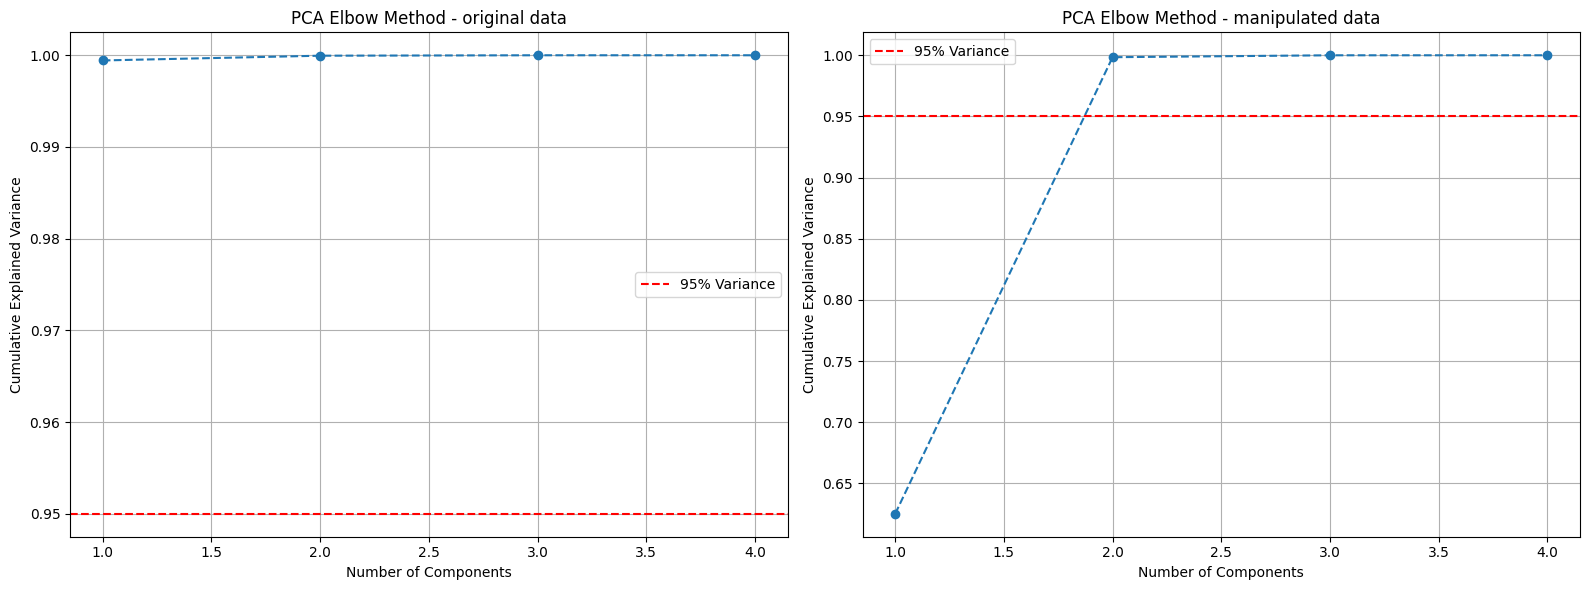

Optimal number of components for original data: 1
Optimal number of components for manipulated data: 2


In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA and fit data for time_window_df
pca1 = PCA()
pca1.fit(time_window_df)

# Get the explained variance ratio
explained_variance_ratio1 = pca1.explained_variance_ratio_
cumulative_explained_variance1 = np.cumsum(explained_variance_ratio1)

# Initialize PCA and fit data for vis_data
pca2 = PCA()
pca2.fit(vis_data)

# Get the explained variance ratio
explained_variance_ratio2 = pca2.explained_variance_ratio_
cumulative_explained_variance2 = np.cumsum(explained_variance_ratio2)

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first PCA (time_window_df)
axes[0].plot(range(1, len(cumulative_explained_variance1) + 1), cumulative_explained_variance1, marker='o', linestyle='--')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA Elbow Method - original data')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[0].legend()
axes[0].grid()

# Plot the second PCA (vis_data)
axes[1].plot(range(1, len(cumulative_explained_variance2) + 1), cumulative_explained_variance2, marker='o', linestyle='--')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('PCA Elbow Method - manipulated data')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].legend()
axes[1].grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the optimal number of components for both datasets
optimal_components1 = np.argmax(cumulative_explained_variance1 >= 0.95) + 1
optimal_components2 = np.argmax(cumulative_explained_variance2 >= 0.95) + 1
print(f"Optimal number of components for original data: {optimal_components1}")
print(f"Optimal number of components for manipulated data: {optimal_components2}")


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=optimal_components2)  
reduced_data = pca.fit_transform(scaled_data)

### 2.E PyOD Implementation
This section performs anomaly detection using multiple base estimators from the PyOD library (LOF, HBOS, PCA, and KNN) on a time series dataset, evaluating their performance in terms of precision, recall, and F1 score. It utilizes the TimeSeriesSplit from sklearn to divide the data into training and testing sets for cross-validation. For each split, synthetic anomalies are introduced into the ground truth labels, and the model is trained in batches to optimize memory usage. The training and inference times for each model are measured, and the results are collected for evaluation. The models' performance metrics are computed and displayed, providing an overall comparison of the different estimators based on their precision, recall, F1 score, and average training and inference times. Parallel processing with CPU is employed to speed up the evaluation across the splits.

In [27]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from joblib import Parallel, delayed

# Define batch size (you can adjust this based on memory constraints)
batch_size = 500  # Adjust batch size as needed
contamination = 0.4

# Base estimators (as in your previous example)
base_estimators = [
    LOF(n_neighbors=5, contamination=contamination),
    LOF(n_neighbors=15, contamination=contamination),
    LOF(n_neighbors=25, contamination=contamination),
    HBOS(contamination=contamination),
    PCA(contamination=contamination),
    KNN(n_neighbors=5, contamination=contamination),
    KNN(n_neighbors=15, contamination=contamination),
    KNN(n_neighbors=25, contamination=contamination)
]

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Function to get outlier indices
def get_outlier_ids(labels):
    return np.where(labels == 1)[0]

# Function to process each split and estimator
def process_split(estimator, train_idx, test_idx, scaled_data, time_window_df, anomaly_dates, batch_size):
    # Prepare train and test data for current split
    train_data, test_data = scaled_data[train_idx], scaled_data[test_idx]
    test_df = time_window_df.iloc[test_idx]

    # Generate synthetic anomalies in the training data for ground truth
    train_anomalies = np.zeros(len(test_df))  # Initialize ground truth labels
    valid_anomaly_indices = [ts for ts in anomaly_dates if ts in test_df.index]
    anomaly_positions = [test_df.index.get_loc(ts) for ts in valid_anomaly_indices]
    train_anomalies[anomaly_positions] = 1  # Set synthetic anomalies in the ground truth

    # Measure training time
    start_time = time.time()
    for i in range(0, len(train_data), batch_size):
        batch_train_data = train_data[i:i + batch_size]
        estimator.partial_fit(batch_train_data) if hasattr(estimator, "partial_fit") else estimator.fit(batch_train_data)
    end_time = time.time()
    training_time = end_time - start_time

    # Get predictions and calculate inference time
    start_time = time.time()
    predictions = estimator.predict(test_data)
    end_time = time.time()
    inference_time = end_time - start_time

    return predictions, train_anomalies, training_time, inference_time

# Initialize lists to store the results
precision_scores = []
recall_scores = []
f1_scores = []
pyod_training_times = []
pyod_inference_times = []

# Parallelizing over estimators
for estimator in base_estimators:
    print(f"Evaluating: {estimator}")
    
    # Parallelize the processing of splits for each estimator
    results = Parallel(n_jobs=-1)(delayed(process_split)(estimator, train_idx, test_idx, reduced_data, time_window_df, anomaly_dates, batch_size)
                                   for train_idx, test_idx in tscv.split(reduced_data))

    # Collect predictions and ground truth labels from all splits
    all_predictions = []
    all_true_labels = []
    training_times = []
    inference_times = []

    for predictions, true_labels, split_training_time, split_inference_time in results:
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)
        training_times.append(split_training_time)
        inference_times.append(split_inference_time)

    # Compute precision, recall, and F1 for the current estimator
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)
    
    # Store the metrics and times
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    pyod_training_times.append(np.mean(training_times))
    pyod_inference_times.append(np.mean(inference_times))

    print(f"Estimator: {estimator}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Avg. Training Time: {np.mean(training_times):.4f}s, Avg. Inference Time: {np.mean(inference_times):.4f}s\n")

# Print the overall metrics
print("\nSummary of Model Performance Across Estimators:")
for i, estimator in enumerate(base_estimators):
    print(f"{estimator}")
    print(f"  Precision: {precision_scores[i]:.4f}")
    print(f"  Recall: {recall_scores[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print(f"  Avg. Training Time: {pyod_training_times[i]:.4f}s")
    print(f"  Avg. Inference Time: {pyod_inference_times[i]:.4f}s")

pyod_precision_scores = precision_scores
pyod_recall_scores = recall_scores
pyod_f1_scores = f1_scores


Evaluating: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)
Estimator: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)
Precision: 0.8919, Recall: 0.5203, F1 Score: 0.6573
Avg. Training Time: 34.5311s, Avg. Inference Time: 1.6767s

Evaluating: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2)
Estimator: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2)
Precision: 0.9032, Recall: 0.5886, F1 Score: 0.7127
Avg. Training Time: 38.3400s, Avg. Inference Time: 2.0259s

Evaluating: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=25, novelty=True, p=2)
Estimator:

### 2.F SUOD Implementation
This section is the same as the previous one except we're using SUOD this time

In [28]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from suod.models.base import SUOD  
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from joblib import Parallel, delayed

# Define batch size (you can adjust this based on memory constraints)
batch_size = 500  # Adjust batch size as needed
contamination = 0.1
n_jobs = min(2, len(base_estimators))


suod_model = SUOD(
    base_estimators=base_estimators,
    n_jobs=n_jobs,  # Number of parallel jobs
    rp_flag_global=True,  # Random projection 
    bps_flag=True,  # Balanced parallel scheduling
    approx_flag_global=False,  # No model approximation
    contamination=contamination
)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Function to get outlier indices
def get_outlier_ids(labels):
    return np.where(labels == 1)[0]

# Function to process each split and estimator
def process_split(estimator, train_idx, test_idx, scaled_data, time_window_df, anomaly_dates, batch_size):
    # Prepare train and test data for current split
    train_data, test_data = scaled_data[train_idx], scaled_data[test_idx]
    test_df = time_window_df.iloc[test_idx]

    # Generate synthetic anomalies in the training data for ground truth
    train_anomalies = np.zeros(len(test_df))  # Initialize ground truth labels
    valid_anomaly_indices = [ts for ts in anomaly_dates if ts in test_df.index]
    anomaly_positions = [test_df.index.get_loc(ts) for ts in valid_anomaly_indices]
    train_anomalies[anomaly_positions] = 1  # Set synthetic anomalies in the ground truth

    # Measure training time
    start_time = time.time()

    for i in range(0, len(train_data), batch_size):
        batch_train_data = train_data[i:i + batch_size]
        estimator.partial_fit(batch_train_data) if hasattr(estimator, "partial_fit") else estimator.fit(batch_train_data)
    end_time = time.time()
    training_time = end_time - start_time

    # Get predictions and calculate inference time
    start_time = time.time()

    predictions = estimator.decision_function(test_data)
    end_time = time.time()
    inference_time = end_time - start_time

    threshold_index = int((1 - contamination) * len(predictions))
    threshold = np.sort(predictions)[threshold_index]
    binary_predictions = (predictions > threshold).astype(int)

    return binary_predictions, train_anomalies, training_time, inference_time

# Initialize lists to store the results
precision_scores = []
recall_scores = []
f1_scores = []
training_times = []
inference_times = []

# Looping over each base estimator
for estimator in suod_model.base_estimators:
    print(f"Evaluating: {estimator}")
    

    # Parallelizing over splits for the current estimator
    results = Parallel(n_jobs=4)(
    delayed(process_split)(estimator, train_idx, test_idx, scaled_data, time_window_df, anomaly_dates, batch_size)
    for train_idx, test_idx in tscv.split(reduced_data)
    )

    # Collect predictions and ground truth labels from all splits
    all_predictions = []
    all_true_labels = []
    estimator_training_times = []
    estimator_inference_times = []

    for predictions, true_labels, split_training_time, split_inference_time in results:
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)
        estimator_training_times.append(split_training_time)
        estimator_inference_times.append(split_inference_time)

    # Compute precision, recall, and F1 for the current estimator
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)
    
    # Store the metrics and times
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    training_times.append(np.mean(estimator_training_times))
    inference_times.append(np.mean(estimator_inference_times))

    print(f"Estimator: {estimator}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Avg. Training Time: {np.mean(estimator_training_times):.4f}s, Avg. Inference Time: {np.mean(estimator_inference_times):.4f}s\n")

# Print overall results
print("\nSummary of Model Performance Across Estimators:")
for i, estimator in enumerate(base_estimators):
    print(f"{estimator}")
    print(f"  Precision: {precision_scores[i]:.4f}")
    print(f"  Recall: {recall_scores[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print(f"  Avg. Training Time: {training_times[i]:.4f}s")
    print(f"  Avg. Inference Time: {inference_times[i]:.4f}s")

suod_precision_scores = precision_scores
suod_recall_scores = recall_scores
suod_f1_scores = f1_scores
suod_training_times = training_times
suod_inference_times = inference_times

Evaluating: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)
Estimator: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)
Precision: 0.8906, Recall: 0.5134, F1 Score: 0.6514
Avg. Training Time: 30.0964s, Avg. Inference Time: 1.7342s

Evaluating: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2)
Estimator: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2)
Precision: 0.9032, Recall: 0.5886, F1 Score: 0.7127
Avg. Training Time: 34.6497s, Avg. Inference Time: 2.0465s

Evaluating: LOF(algorithm='auto', contamination=0.4, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=25, novelty=True, p=2)
Estimator:

### 2.G TOD Implementation (Not Working)
This section is the same as the previous ones except we're using PyTOD which I can't get it to work. From my long experiments, I have concluded that I'm not able to make this work due to numerical instability. PyTOD simply cannot handle the huge dataset that we have. We should keep in mind that yes PyTOD has really quick inference times but may not be reliable in certain datasets like this one where there are resulting decision scores that are nAn values. I did every data manipulation by the book (standard scaling, min max scaling, robust scaling, clipping, PCA, etc.) and it still resulted to nAn values when doing batch training using PyTOD meanwhile PyOD and SUOD are working perfectly fine

In [29]:
from sklearn.preprocessing import RobustScaler
import numpy as np
from numpy import percentile
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from pytod.models.knn import KNN
from pytod.models.hbos import HBOS
from pytod.models.pca import PCA
from pytod.models.lof import LOF
from joblib import Parallel, delayed
from scipy.stats import zscore

torch.cuda.empty_cache()
# Define contamination and batch size
contamination = 0.1
batch_size = 500  # Adjust based on memory constraints

# Define base estimators
base_estimators = []
device = 'cuda'
batch_size = 5000
# LOF parameter configurations
lof_params = [
    {'n_neighbors': 5, 'contamination': contamination, 'batch_size': batch_size, 'device': device},
    {'n_neighbors': 15, 'contamination': contamination, 'batch_size': batch_size, 'device': device},
    {'n_neighbors': 25, 'contamination': contamination, 'batch_size': batch_size, 'device': device},
]

for params in lof_params:
    base_estimators.append(LOF(**params))

base_estimators.append(HBOS(contamination=contamination, n_bins=50))
base_estimators.append(PCA(contamination=contamination, n_components=4))

# KNN parameter configurations
knn_params = [
    {'n_neighbors': 5, 'contamination': contamination, 'batch_size': batch_size},
    {'n_neighbors': 15, 'contamination': contamination, 'batch_size': batch_size},
    {'n_neighbors': 25, 'contamination': contamination, 'batch_size': batch_size},
]

for params in knn_params:
    base_estimators.append(KNN(**params))

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Function to process each split and estimator
def process_split(estimator, train_idx, test_idx, scaled_data, time_window_df, anomaly_dates, batch_size):

    train_data, test_data = scaled_data[train_idx], scaled_data[test_idx]
    test_df = time_window_df.iloc[test_idx]


    # Generate synthetic anomalies in the test data for ground truth
    train_anomalies = np.zeros(len(test_df))
    valid_anomaly_indices = [ts for ts in anomaly_dates if ts in test_df.index]
    anomaly_positions = [test_df.index.get_loc(ts) for ts in valid_anomaly_indices]
    train_anomalies[anomaly_positions] = 1

    # Training and inference timing
    start_time = time.time()
    #print(f"Fitting {estimator.__class__.__name__}...")
    
    train_tensor = torch.from_numpy(train_data).float()
    variance = train_tensor.var(dim=0, unbiased=False)  # Use PyTorch's `var` method
    print("Variance of each column:", variance)
    correlation_matrix = torch.corrcoef(train_tensor.T)
    print("Correlation matrix:\n", correlation_matrix)


    print(train_tensor.shape)
    print(train_tensor.shape)
    estimator.fit(train_tensor)
    print(estimator.decision_scores_)

    end_time = time.time()
    training_time = end_time - start_time

    # Inferencing
    predictions = []
    print("Start inferencing")
    print(f"test data length: {len(test_data)}")
    start_time = time.time()
    num_batches = 5000
    test_batch_size = len(test_data)//num_batches
    for batch_idx in range(num_batches):
        start_idx = batch_idx * test_batch_size
        end_idx = (batch_idx + 1) * test_batch_size if batch_idx < num_batches - 1 else len(test_data)
        
        batch_data = test_data[start_idx:end_idx]
        batch_data = np.array(batch_data) 
        batch_predictions = estimator.predict(batch_data, return_confidence=False)
    
        predictions.extend(batch_predictions)


    if predictions is None:
        raise ValueError("estimator.decision_function returned None")
    

    end_time = time.time()
    inference_time = end_time - start_time
    print(f"predictions length: {len(predictions)}")
    predictions = np.array(predictions)
    return predictions, train_anomalies, training_time, inference_time

# Initialize lists to store results
precision_scores = []
recall_scores = []
f1_scores = []
training_times = []
inference_times = []

# Loop over each TOD estimator
for estimator in base_estimators:
    print(f"Evaluating: {estimator}")

    # Parallelize over splits for the current estimator
    # Parallelizing over splits for the current estimator
    for train_idx, test_idx in tscv.split(scaled_data):
        print("start")
        process_split(estimator, train_idx, test_idx, scaled_data, time_window_df, anomaly_dates, batch_size)
        torch.cuda.empty_cache()

    # Parallelizing over splits for the current estimator
    #results = Parallel(n_jobs=4)(
    #delayed(process_split)(estimator, train_idx, test_idx, scaled_data, time_window_df, anomaly_dates, batch_size)
    #for train_idx, test_idx in tscv.split(scaled_data)
    #)
        
    # Collect predictions and ground truth labels from all splits
    all_predictions = []
    all_true_labels = []
    estimator_training_times = []
    estimator_inference_times = []


    for predictions, true_labels, split_training_time, split_inference_time in results:
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)
        estimator_training_times.append(split_training_time)
        estimator_inference_times.append(split_inference_time)

    # Compute precision, recall, and F1 for the current estimator
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)

    # Store the metrics and times
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    training_times.append(np.mean(estimator_training_times))
    inference_times.append(np.mean(estimator_inference_times))

    print(f"Estimator: {estimator}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Avg. Training Time: {np.mean(estimator_training_times):.4f}s, Avg. Inference Time: {np.mean(estimator_inference_times):.4f}s\n")

# Print overall results
print("\nSummary of Model Performance Across Estimators:")
for i, estimator in enumerate(base_estimators):
    print(f"{estimator}")
    print(f"  Precision: {precision_scores[i]:.4f}")
    print(f"  Recall: {recall_scores[i]:.4f}")
    print(f"  F1 Score: {f1_scores[i]:.4f}")
    print(f"  Avg. Training Time: {training_times[i]:.4f}s")
    print(f"  Avg. Inference Time: {inference_times[i]:.4f}s")

tod_precision_scores = precision_scores
tod_recall_scores = recall_scores
tod_f1_scores = f1_scores
tod_training_times = training_times
tod_inference_times = inference_times


Evaluating: LOF(batch_size=5000, contamination=0.1, device='cuda', n_neighbors=5)
start


KeyboardInterrupt: 

### 2.H Final Results
This section shows the results of PyOD and SUOD's metrics including training time, inference time, precision, recall, and f1 scores including a bar graph to visualize these metrics

               Model PyOD Training Time SUOD Training Time PyOD Inference Time SUOD Inference Time PyOD Precision SUOD Precision PyOD Recall SUOD Recall   PyOD F1   SUOD F1
 LOF (n_neighbors=5)          34.531101          30.096415            1.676729            1.734225       0.891933       0.890637     0.52035    0.513433  0.657258  0.651367
LOF (n_neighbors=15)          38.340027          34.649746            2.025882            2.046521       0.903237       0.903237    0.588551    0.588551  0.712703  0.712703
LOF (n_neighbors=25)          41.827904          36.054369            2.503577            2.332205       0.903237       0.903237    0.588552    0.588552  0.712704  0.712704
                HBOS          10.511401           7.290129            0.040557            0.059782       0.949186       0.939305    0.382613    0.466171  0.545384  0.623101
                 PCA           9.733087           6.992149            0.068228            0.076947       0.913959       0.935231    0.4

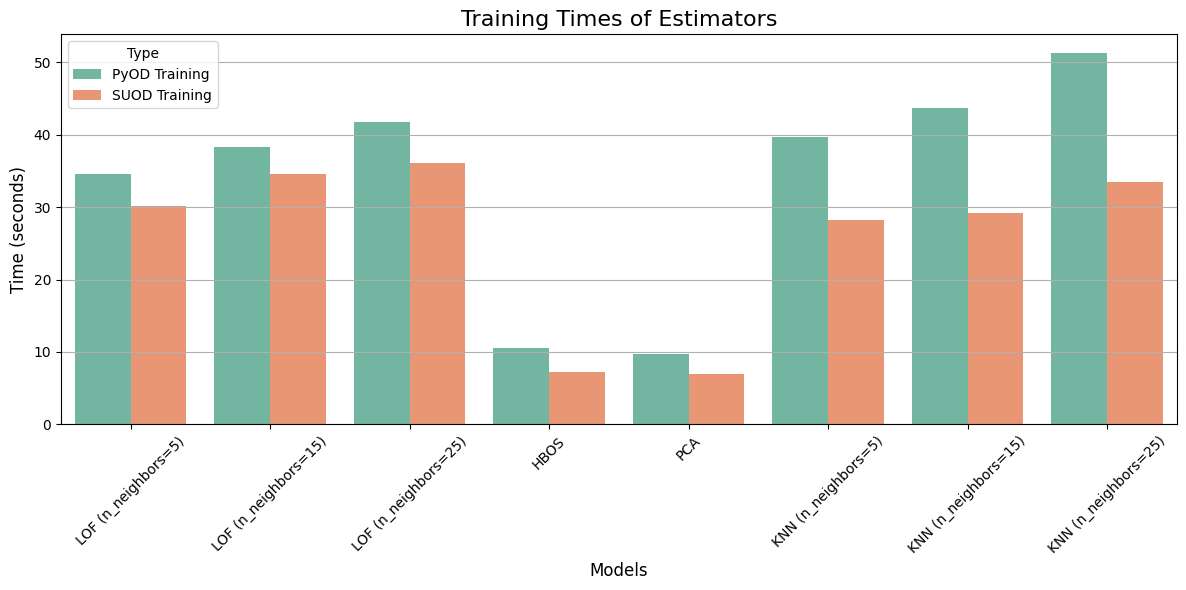

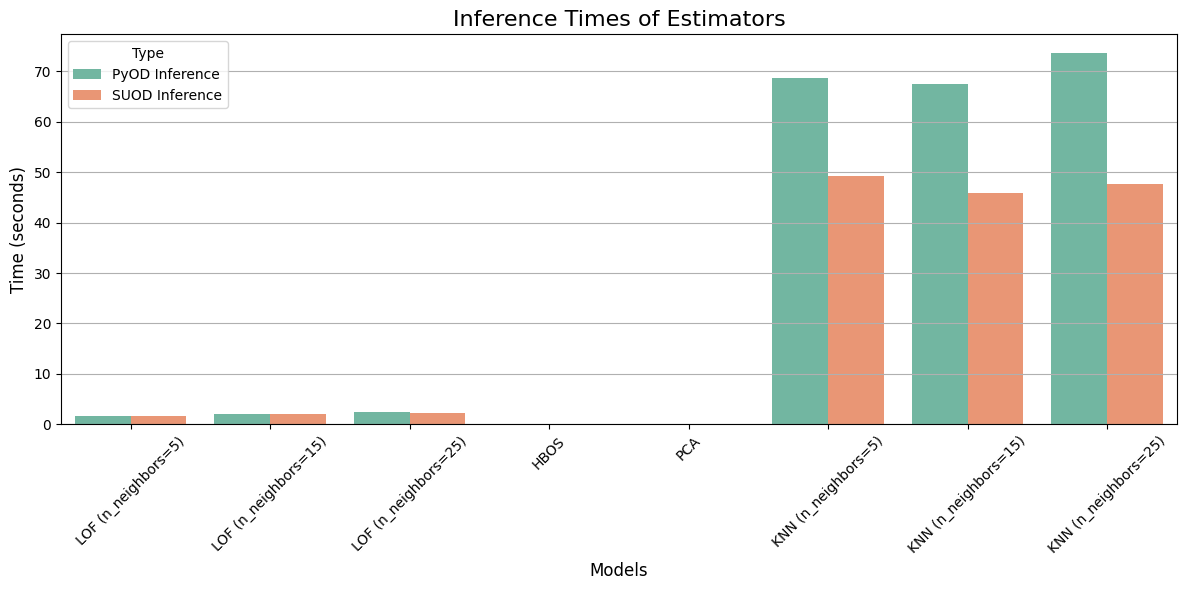

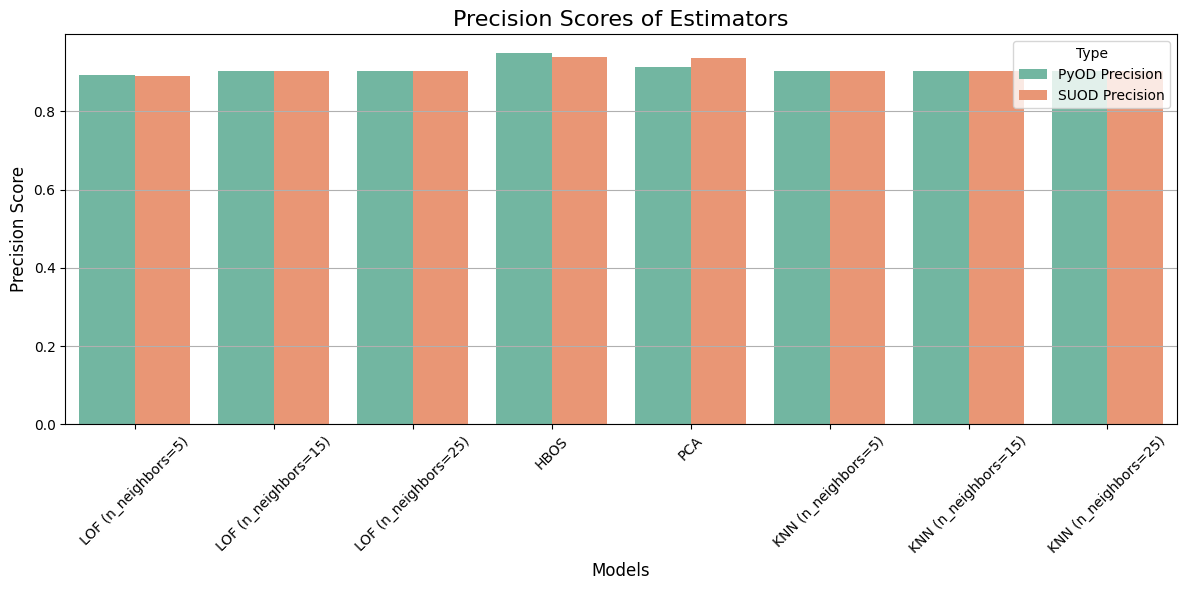

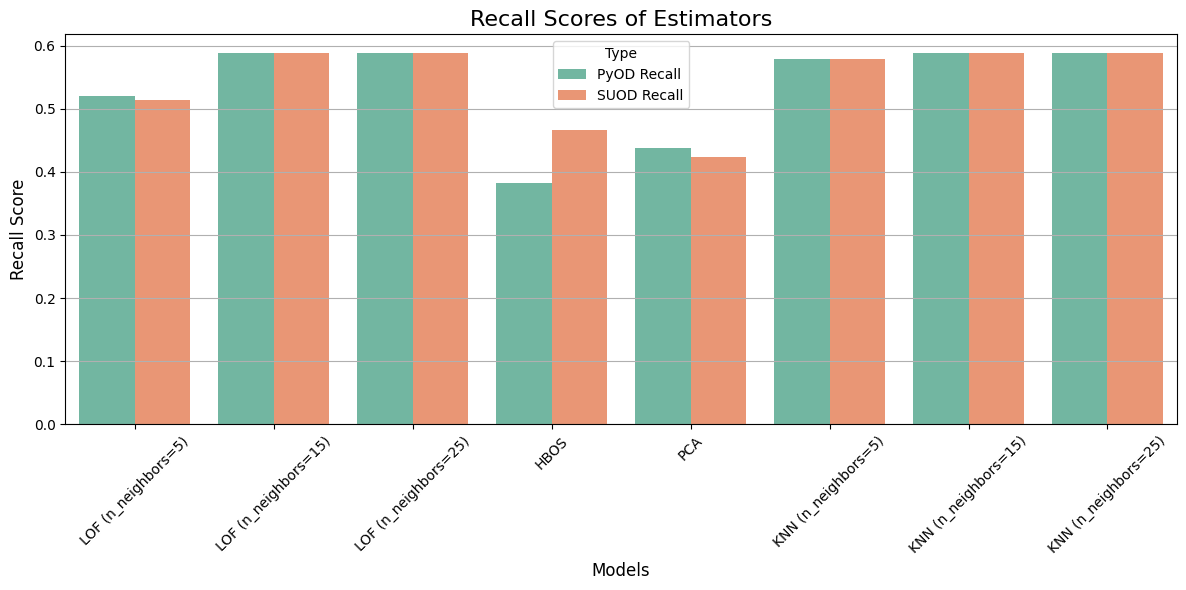

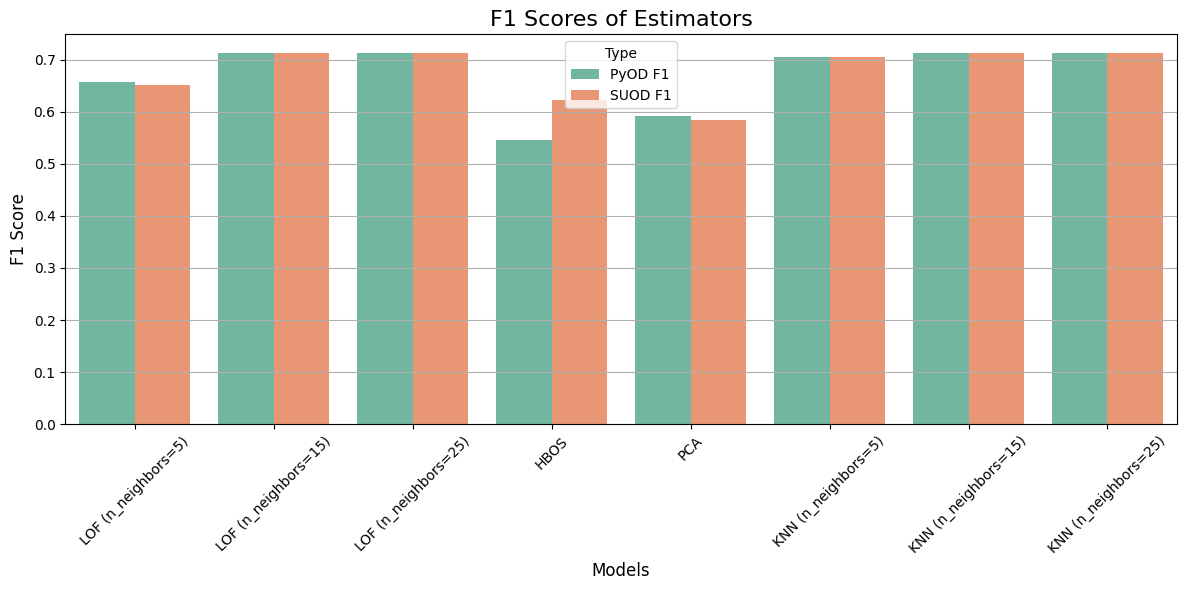

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the results DataFrame with precision, recall, and F1 scores
results_df = pd.DataFrame({
    'Model': model_names,
    'PyOD Training Time': pyod_training_times,
    'SUOD Training Time': suod_training_times,
    'PyOD Inference Time': pyod_inference_times,
    'SUOD Inference Time': suod_inference_times,
    'PyOD Precision': pyod_precision_scores,
    'SUOD Precision': suod_precision_scores,
    'PyOD Recall': pyod_recall_scores,
    'SUOD Recall': suod_recall_scores,
    'PyOD F1': pyod_f1_scores,
    'SUOD F1': suod_f1_scores
})

# Calculate totals for PyOD and SUOD
totals_df = pd.DataFrame({
    'Model': ['Total PyOD', 'Total SUOD'],
    'PyOD Training Time': [sum(pyod_training_times), '____'],
    'SUOD Training Time': ['____', sum(suod_training_times)],
    'PyOD Inference Time': [sum(pyod_inference_times), '____'],
    'SUOD Inference Time': ['____', sum(suod_inference_times)],
    'PyOD Precision': [sum(pyod_precision_scores), '____'],
    'SUOD Precision': ['____', sum(suod_precision_scores)],
    'PyOD Recall': [sum(pyod_recall_scores), '____'],
    'SUOD Recall': ['____', sum(suod_recall_scores)],
    'PyOD F1': [sum(pyod_f1_scores), '____'],
    'SUOD F1': ['____', sum(suod_f1_scores)]
})

# Combine individual results with totals
final_results_df = pd.concat([results_df, totals_df], ignore_index=True)

# Print the final results DataFrame
print(final_results_df.to_string(index=False))

# Prepare data for plotting (Training Times)
data_training = {
    'Model': model_names * 2,  
    'Time': pyod_training_times + suod_training_times,
    'Type': ['PyOD Training'] * len(pyod_training_times) +
            ['SUOD Training'] * len(suod_training_times)
}

# Prepare data for plotting (Inference Times)
data_inference = {
    'Model': model_names * 2,  
    'Time': pyod_inference_times + suod_inference_times,
    'Type': ['PyOD Inference'] * len(pyod_inference_times) +
            ['SUOD Inference'] * len(suod_inference_times)
}


# Prepare data for precision, recall, and F1 scores
data_precision = {
    'Model': model_names * 2,
    'Score': pyod_precision_scores + suod_precision_scores,
    'Type': ['PyOD Precision'] * len(pyod_precision_scores) +
            ['SUOD Precision'] * len(suod_precision_scores)
}

data_recall = {
    'Model': model_names * 2,
    'Score': pyod_recall_scores + suod_recall_scores,
    'Type': ['PyOD Recall'] * len(pyod_recall_scores) +
            ['SUOD Recall'] * len(suod_recall_scores)
}

data_f1 = {
    'Model': model_names * 2,
    'Score': pyod_f1_scores + suod_f1_scores,
    'Type': ['PyOD F1'] * len(pyod_f1_scores) +
            ['SUOD F1'] * len(suod_f1_scores)
}

# Convert data into DataFrames
df_training = pd.DataFrame(data_training)
df_inference = pd.DataFrame(data_inference)
df_precision = pd.DataFrame(data_precision)
df_recall = pd.DataFrame(data_recall)
df_f1 = pd.DataFrame(data_f1)

# Plot training times
plt.figure(figsize=(12, 6))
sns.barplot(data=df_training, x='Model', y='Time', hue='Type', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Training Times of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot inference times
plt.figure(figsize=(12, 6))
sns.barplot(data=df_inference, x='Model', y='Time', hue='Type', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Inference Times of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot Precision Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=df_precision, x='Model', y='Score', hue='Type', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Precision Score', fontsize=12)
plt.title('Precision Scores of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot Recall Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=df_recall, x='Model', y='Score', hue='Type', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.title('Recall Scores of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot F1 Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=df_f1, x='Model', y='Score', hue='Type', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Scores of Estimators', fontsize=16)
plt.legend(title='Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 2.I Final Results
As shown from the results, PCA and HBOS have the fastest training and inference times while LOF is trailing near with just a few seconds (+2 seconds) in inference times. From the comparison, it seems that SUOD is faster than PyOD and has nearly similar results in precision, recall and f1 when compared to PyOD. In this scenario, SUOD with LOF was able to perform the best (n_neighbors=25). Sure the training times are a bit longer but inference time increase is negligible compared to different n_neighbors = 5 and n_neighbors = 15 and it was able to get better results.

What we can questions is how these models weren't able to perform as expected. Precision is in the renga eof 80% while recall and f1 score is around 0.50-0.70 which is less than expected. A good precision means the models' anomaly predictions are mostly correct but they're not able to spot all the anomalies. This brings up specific problems when it comes to TSAD.

- Class imbalance: of course in a TSAD dataset, there is way less anomalous data points than normal ones. Will try to use Synthetic Minority Oversampling Technique (SMOTE) as it may handle this issue well. But we're actually the ones who can define the number of anomalous datapoints since we're the ones injecting these artificial points. I can try increasing the number of anomalous data points but that has shown to increase the positive correlations between variables which is problematic since it means that features are becoming more redundant and also a bigger number of anomalous data points does not depict real world data. 

- Maybe I overdid the random injection of anomalous points. Maybe I made the anomalies too subtle that it is already hard enough for the models to spot. You can check 2.C.1 if the injected points are too "lowkey"

- The dataset is too big. I don't think we'll be dealing with 7 million data points, are we? 